In [1]:
import ray
from ray.rllib.env import PettingZooEnv
from ray.tune.registry import register_env
from pettingzoo.classic import texas_holdem_v4

import gymnasium as gym

RAISE_ACTION = 1 
# In here penalize the reward by making it expensive a bit
class RaisePenaltyWrapper(PettingZooEnv):
    def __init__(self, env, positive_penalize=1, negative_penalize=1):
        super().__init__(env)
        self.positive_penalize = positive_penalize
        self.negative_penalize = negative_penalize

    def step(self, action_dict):
        obs, rewards, terminations, truncations, infos = super().step(action_dict)

        new_rewards = {}

        for agent_id, r in rewards.items():
            a = action_dict.get(agent_id, None)

            # 1) small penalty per raise
            if a == RAISE_ACTION:
                r -= 0.05

            # 2) asymmetric win/loss scaling at terminal
            done = terminations.get(agent_id, False) or truncations.get(agent_id, False)
            if done:
                if r > 0:
                    r = self.positive_penalize * r
                elif r < 0:
                    r = self.negative_penalize * r

            new_rewards[agent_id] = r
        return obs, new_rewards, terminations, truncations, infos


def env_creator(config=None):
    # raw PettingZoo AEC env
    env = texas_holdem_v4.env()
    env.reset(seed=(config or {}).get("seed", None))
    # RLlib wrapper so it looks like a MultiAgentEnv
    #env = PettingZooEnv(env)
    wrapper_env = RaisePenaltyWrapper(
        env,
        positive_penalize=0.75,
        negative_penalize=1.5,
    )
    return wrapper_env

env_name = "texas_holdem_v4"
register_env(env_name, lambda config: env_creator(config))

# Create one test env to grab spaces
test_env = env_creator()
obs_space = test_env.observation_space
act_space = test_env.action_space

/opt/homebrew/anaconda3/envs/ray_new/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
test_env = texas_holdem_v4.env(render_mode="human")
test_env.reset()
obs, reward, termination, truncation, info = test_env.last()

print("obs['observation'].shape:", obs["observation"].shape)
print("obs['action_mask']:", obs["action_mask"])

obs['observation'].shape: (72,)
obs['action_mask']: [1 1 1 0]


In [3]:
from pettingzoo.classic import texas_holdem_v4

env = texas_holdem_v4.env(render_mode="human")
env.reset(seed=42)

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        mask = observation["action_mask"]
        # this is where you would insert your policy
        action = env.action_space(agent).sample(mask)

    env.step(action)
env.close()


In [41]:
obs_space

Dict('player_0': Dict('action_mask': Box(0, 1, (4,), int8), 'observation': Box(0.0, 1.0, (72,), float32)), 'player_1': Dict('action_mask': Box(0, 1, (4,), int8), 'observation': Box(0.0, 1.0, (72,), float32)))

In [42]:
act_space

Dict('player_0': Discrete(4), 'player_1': Discrete(4))

In [60]:
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork
from ray.rllib.utils.framework import try_import_torch
import gymnasium as gym

torch, nn = try_import_torch()

import numpy as np
import gymnasium as gym

from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.framework import try_import_torch

torch, nn = try_import_torch()

class FlatActionMaskingModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        print(">>> FlatActionMaskingModel obs_space:", obs_space)
        print(">>> type(obs_space):", type(obs_space))

        if not isinstance(obs_space, gym.spaces.Box):
            raise ValueError(
                f"Expected flat Box obs space, got {obs_space!r} "
                f"(type={type(obs_space)})"
            )

        flat_dim = int(np.prod(obs_space.shape))
        mask_dim = action_space.n          # Discrete(4) -> 4
        obs_dim = flat_dim - mask_dim

        if obs_dim <= 0:
            raise ValueError(
                f"flat_dim ({flat_dim}) <= mask_dim ({mask_dim}); "
                f"can't split into obs + mask."
            )

        self.obs_dim = obs_dim
        self.mask_dim = mask_dim

        # Build a base FC net over the obs part only
        obs_low = np.full((obs_dim,), obs_space.low.min(), dtype=np.float32)
        obs_high = np.full((obs_dim,), obs_space.high.max(), dtype=np.float32)
        obs_box = gym.spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        self.base_model = FullyConnectedNetwork(
            obs_space=obs_box,
            action_space=action_space,
            num_outputs=num_outputs,  # should be 4
            model_config=model_config,
            name=name + "_fcnet",
        )

    def forward(self, input_dict, state, seq_lens):

        # RLlib already flattened Dict(observation, action_mask) to a Box(76,)
        # print("----------")
        # print(input_dict["obs"])
        # print("----------")
        flat = input_dict["obs"].float()   # [B, 76]

        # Correct split: first 4 dims are mask, remaining are obs
        raw_mask = flat[..., :self.mask_dim]        # [B, 4]
        obs      = flat[..., self.mask_dim:]

        # Force mask to 0/1
        legal_mask = (raw_mask > 0.5).float()


        # Debug: print first few masks once per worker
        # if flat.abs().sum() == 0:
        #     print("\n=== DUMMY BATCH (all zeros) ===")
        # else:
        #     print("\n=== REAL BATCH ===")
        #     print("raw_mask[0]:", raw_mask[0].detach().cpu().numpy())
        #     print("legal_mask[0]:", legal_mask[0].detach().cpu().numpy())
        #     print("obs[0, :10]:", obs[0, :10].detach().cpu().numpy())
        #     print("=====================================\n")


        # Base model only sees the obs part
        logits, _ = self.base_model({"obs": obs}, state, seq_lens)  # [B, mask_dim]

        # Mask: legal → 0, illegal → -inf
        inf = torch.finfo(logits.dtype).min
        mask_add = (1.0 - legal_mask) * inf
        masked_logits = logits + mask_add

        return masked_logits, state

    def value_function(self):
        return self.base_model.value_function()


In [61]:
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.ppo import PPOConfig
import gymnasium as gym
from ray.rllib.policy.policy import PolicySpec

# Option A: two separate policies (one per seat)
config = (
    PPOConfig()
    .environment(env=env_name)
    .framework("torch")
    .env_runners(num_env_runners=4, create_env_on_local_worker=True,)
    .training(
        gamma=0.99,
        lambda_=0.95,
        lr=5e-4,
        train_batch_size=8192,
        minibatch_size=1024,
        num_sgd_iter=8,
        entropy_coeff=0.01,  #penalize the deterministic policy
        entropy_coeff_schedule=None,
        model={
            "custom_model": FlatActionMaskingModel,
            "fcnet_hiddens": [256, 256],
            "fcnet_activation": "tanh",
            "_disable_preprocessor_api": True,
        }
    )
    .multi_agent(
        # policies={
        #     "shared_policy": PolicySpec(
        #         observation_space=obs_space["player_0"],
        #         action_space=act_space["player_0"],
        #         config={},
        #     ),
        # },
        # policy_mapping_fn=lambda agent_id, *a, **k: "shared_policy",

        policies={
            "player_0": PolicySpec(observation_space=obs_space['player_0'],
                action_space=act_space['player_0'],
                config={},),
            "player_1": PolicySpec(observation_space=obs_space['player_1'],
                action_space=act_space['player_1'],
                config={},),
        },
        # in this env the agent_ids are literally "player_0"/"player_1"
        policy_mapping_fn=lambda agent_id, *a, **k: agent_id,
    )
    .api_stack(  # <-- turn ON the new stack explicitly
        enable_rl_module_and_learner=False,
        enable_env_runner_and_connector_v2=False,
    )
    #.experimental(_validate_config=False)
)


algo = config.build_algo()


2025-12-01 19:22:30,578	WARNING algorithm_config.py:2484 -- DeprecationWarning: `config.training(num_sgd_iter=..)` has been deprecated. Use `config.training(num_epochs=..)` instead. This will raise an error in the future!
2025-12-01 19:22:35,237	WARNING util.py:61 -- Install gputil for GPU system monitoring.


>>> FlatActionMaskingModel obs_space: Box(-1.0, 1.0, (76,), float32)
>>> type(obs_space): <class 'gymnasium.spaces.box.Box'>
>>> FlatActionMaskingModel obs_space: Box(-1.0, 1.0, (76,), float32)
>>> type(obs_space): <class 'gymnasium.spaces.box.Box'>


In [62]:
import collections

env = env_creator({})

def eval_one_episode(render=False):
    obs, info = env.reset()
    done = False

    # Start empty; we'll add agents as we see them
    ep_reward = collections.defaultdict(float)
    length = 0

    while not done:
        if render:
            env.render()

        actions = {}
        print(obs.items())
        for agent_id, agent_obs in obs.items():
            action = algo.compute_single_action(
                agent_obs,
                policy_id=agent_id,
                explore=False,
            )
            actions[agent_id] = int(action)  # Discrete(4) -> int

        obs, rewards, terminated, truncated, infos = env.step(actions)
        length += 1

        # accumulate rewards; skip special keys like "__all__"
        for aid, r in rewards.items():
            if aid == "__all__":
                continue
            ep_reward[aid] += r

        # episode done: use "__all__" if provided, else fall back
        if "__all__" in terminated:
            done = terminated["__all__"] or truncated.get("__all__", False)
        else:
            done = all(terminated.values()) or all(truncated.values())

    return dict(ep_reward), length

# Run ONE eval episode
ep_rew, ep_len = eval_one_episode(render=False)
print("Episode length:", ep_len)
print("Episode rewards:", ep_rew)


dict_items([('player_0', {'observation': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0.], dtype=float32), 'action_mask': array([1, 1, 1, 0], dtype=int8)})])
dict_items([('player_1', {'observation': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0.], dtype=float32), 'action_mask': array([1, 1, 1, 0], dtype=int8)})])
dict_items([('player_0', {'observation': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0

In [63]:
rewards = []
lengths = []
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

import torch
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

plot_handle = display(None, display_id=True)

def plot_metrics(rew_player0, rew_player1, lengths, curr_iter=0, sum_iter=0):
    fig = plt.figure(1, figsize=(16, 8))
    plt.clf()

    # Subplots
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    # ---- Reward subplot ----
    ax1.set_title(f"Mean Rewards (2 Agents) {curr_iter}/{sum_iter}")
    ax1.set_xlabel("Eval Interval")
    ax1.set_ylabel("Mean Reward")

    ax1.plot(rew_player0, label="player_0", color="blue")
    ax1.plot(rew_player1, label="player_1", color="red")
    ax1.legend()

    # ---- Episode length subplot ----
    ax2.set_title(f"Mean Episode Length {curr_iter}/{sum_iter}")
    ax2.set_xlabel("Eval Interval")
    ax2.set_ylabel("Episode Length")
    ax2.plot(lengths, label="episode length", color="green")

    # Display
    display(fig)
    #plot_handle.update(fig)
    clear_output(wait=True)


None

In [64]:
a1_reward = []
a2_reward = []

Training:   0%|          | 0/10 [00:37<?, ?iter/s]


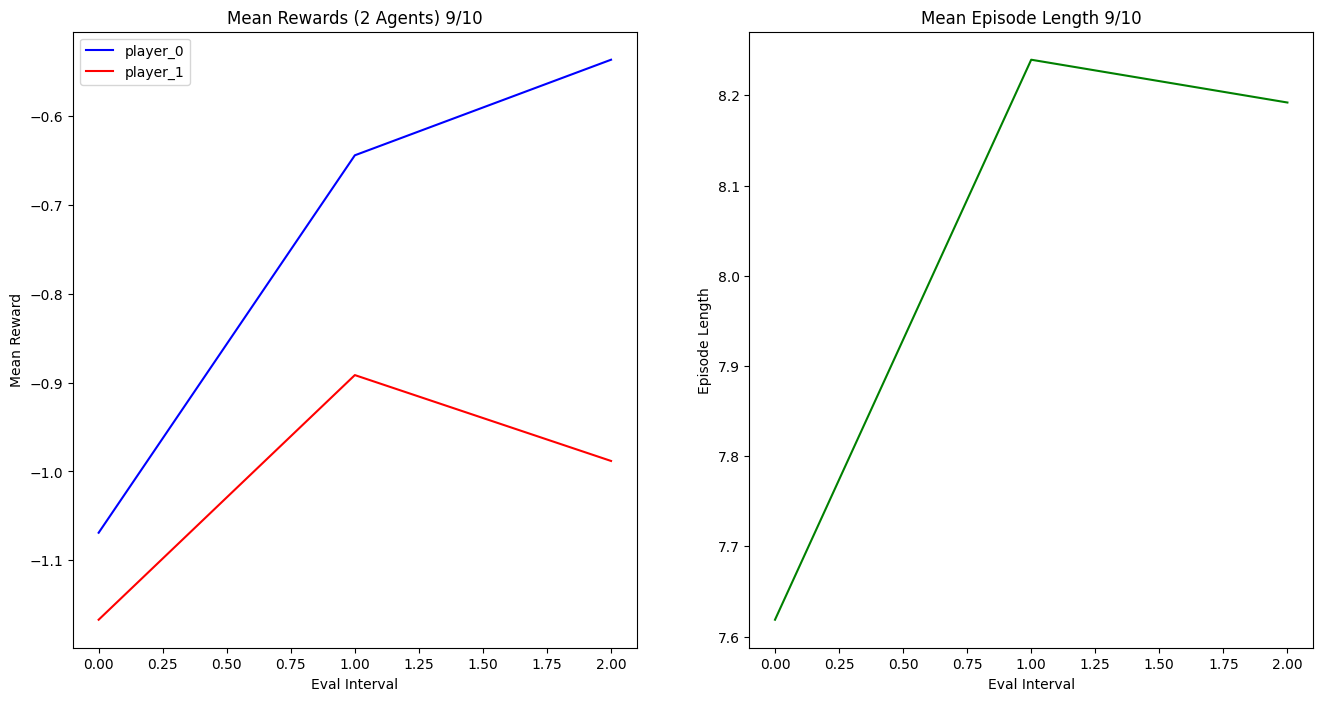

In [72]:
TRAINING_ITERATIONS = 10
# it would be extreme hard to train a two agents env since both could changes alot when training
# and possibily degenerate after they both learn some kind of reward rule of env

# after few test, i train out a model which can generate 2.3-3.2 z score model compare to random no fold model for 10k runs test
import pickle
EVAL_INTERVAL = 10
from tqdm import tqdm

with tqdm(total=TRAINING_ITERATIONS, desc="Training", unit="iter") as pbar:
    for i in range(TRAINING_ITERATIONS):
        algo.train()

        if (i+1) % EVAL_INTERVAL == 0:
            # metrics = algo.evaluate()['evaluation']
            # rewards.append(metrics['episode_reward_mean'])
            # lengths.append(metrics['episode_len_mean'])
            metrics = algo.evaluate()
            metrics = metrics["env_runners"]

            # r_mean = metrics["episode_return_mean"]
            a1_reward.append(metrics["policy_reward_mean"]["player_0"])
            a2_reward.append(metrics["policy_reward_mean"]["player_1"])
            l_mean = metrics["episode_len_mean"]

            # rewards.append(r_mean)
            lengths.append(l_mean)
            plot_metrics(a1_reward, a2_reward, lengths, i, TRAINING_ITERATIONS)
            algo.save("./checkpoints_3_sep")
        #pbar.update(1)

it would be extreme hard to train a two agents env since both could changes alot when training
and possibily degenerate after they both learn some kind of reward rule of env

after few test run, i train out a model which can generate 2.3-3.2 z score when compare to random no fold model for 10k runs test, which means it catch several signal correctly of the game

In [54]:
import numpy as np

SUITS = ["Spades", "Hearts", "Diamonds", "Clubs"]
RANKS = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K"]

def decode_visible_cards(obs_dict):
    """Return list of human-readable cards visible to this player."""
    vec = obs_dict["observation"]
    # ensure it's a flat array
    vec = np.array(vec).astype(int)

    cards_bits = vec[:52]
    cards = []
    for i, bit in enumerate(cards_bits):
        if bit == 1:
            suit = SUITS[i // 13]
            rank = RANKS[i % 13]
            cards.append(f"{rank} of {suit}")
    return cards
ACTION_NAMES = {
    0: "Call",
    1: "Raise",
    2: "Fold",
    3: "Check",
}


In [1]:
import imageio
import torch
from PIL import Image

rmode = "rgb_array"

env = texas_holdem_v4.env(render_mode=rmode)
env.reset()
frames = []
test = 1
rewards = [0, 0, 0]
battle = [0, 0, 0]
run = 1 if test == 0 else 10000
p_reward = []
for i in range(run):
    for agent in env.agent_iter():
        print("-------------------")
        print(agent)
        obs, reward, termination, truncation, info = env.last()
        print(termination)
        # print(observation)
        visible_cards = decode_visible_cards(obs)
        print("Visible cards:", visible_cards)
        print("Reward so far:", reward)
        if reward > 0 or reward <0:
            if agent == "player_0":
                rewards[0] += reward
                p_reward.append(reward)
                if termination and reward>1:
                    battle[0] +=1
            else:
                rewards[1] += reward
                if termination and reward>1:
                    battle[1] +=1
        elif termination and reward ==0:
            rewards[2] += 1
            battle[2] +=1
        if termination or truncation:
            action = None
            print("-------------------")
        else:
            rllib_obs = {
                    "action_mask": obs["action_mask"],
                    "observation": obs["observation"],
                }

            # policy_id MUST match the agent name ("player_0" / "player_1")
            if test == 1:
                if agent=="player_0":
                    action = algo.compute_single_action(
                            rllib_obs,
                            policy_id=agent,
                            explore=False,      # deterministic eval
                    )
                else:
                    #print(obs["action_mask"])
                    mask = obs["action_mask"]
                    lg_action = np.where(mask == 1)[0]
                    action = np.random.choice(lg_action)
                    while action ==2:
                        action = np.random.choice(lg_action)
                    
            else:
                action = algo.compute_single_action(
                            rllib_obs,
                            policy_id=agent,
                            explore=False,      # deterministic eval
                )
            action_name = ACTION_NAMES.get(int(action), f"Unknown({action})")

            print("Chosen action:", action_name)
            print("-------------------")
        if rmode == "rgb_array" and test ==0:
            frame = env.render()
            if frame is not None:
                frames.append(frame)
        env.step(action)
    env.reset()

env.close()


if rmode != "human" and test ==0:
   imageio.mimsave("ppo_poke_sep.gif", frames, fps=2)
   print("Saved to ppo_poke_sep.gif")
print("p1 win, p2 win, tie", battle)
print("p1_cumulative_reward, p2_cumulative_reward, tie: ", rewards)


NameError: name 'texas_holdem_v4' is not defined

Model result shows a conservative yet meaningful choice of action (call for both for most time), which is what i expect for such training, since it should only raise with high confidence for such level of model.

In [78]:
#algo.save("./checkpoints_3_sep_30epoch")

TrainingResult(checkpoint=Checkpoint(filesystem=local, path=./checkpoints_3_sep_30epoch), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'player_0': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float32(1.2268085), 'cur_kl_coeff': np.float64(2.2888183593750003e-06), 'cur_lr': np.float64(0.0005), 'total_loss': np.float64(2.529270902276039), 'policy_loss': np.float64(-0.012429359270754503), 'vf_loss': np.float64(2.543842099606991), 'vf_explained_var': np.float64(-0.09815293923020363), 'kl': np.float64(0.00478024433515456), 'entropy': np.float64(0.2141833920031786), 'entropy_coeff': np.float64(0.01)}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': np.float64(1019.5), 'num_grad_updates_lifetime': np.float64(1032.5), 'diff_num_grad_updates_vs_sampler_policy': np.float64(15.5)}, 'player_1': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float32(1.9030006), 'cur_kl_coeff': np.float64(3.433227539062

In [157]:
se = np.std(p_reward)/np.sqrt(len(p_reward))
print(np.mean(p_reward))
print(se)
# z score
print(np.mean(p_reward)/se)

0.2192753471859664
0.07529760651577522
2.9121157674517466


In [149]:
np.mean(p_reward)/10000

np.float64(2.379862700228833e-05)

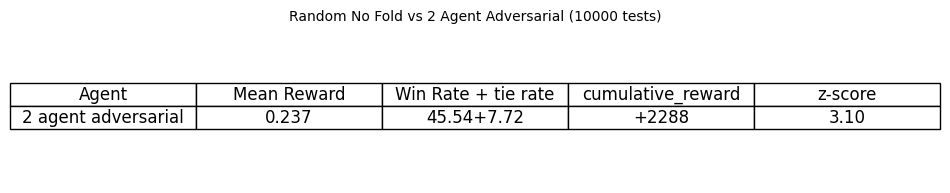

In [153]:
import matplotlib.pyplot as plt

# Data for table 2
data2 = [
    ["2 agent adversarial", "0.237", "45.54+7.72", "+2288", "3.10"]
]

columns2 = ["Agent", "Mean Reward", "Win Rate + tie rate", "cumulative_reward", "z-score"]

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')

table2 = ax.table(
    cellText=data2,
    colLabels=columns2,
    loc='center',
    cellLoc='center'
)

table2.auto_set_font_size(False)
table2.set_fontsize(12)
table2.scale(1.2, 1.4)

plt.title("Random No Fold vs 2 Agent Adversarial (10000 tests)", fontsize=10)
plt.savefig("share_vs_sep_policy_performance/table_2aa.png", dpi=200, bbox_inches='tight')
plt.show()